# Drop-out experiments
Instead of looking at the whole seven-member community, I am creating drop-out communities with only six instead of seven members, With these communities we want investigate community stability and the influence each species has on the whole community.

# Imports and Load Individual Models

In [2]:
# basic
import os

# see functions.py for a collection of self-written functions for analysing and visualising my models
from functions import *

# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from micom import Community
from micom import load_pickle

# plots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# scikit learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS

# umap-learn package
import umap


In [3]:
# Load SBML Models - individuals
models_path = "../Models/12_gap_filled/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


# Functions

In [4]:
def e_to_m(medium):
    if isinstance(medium, dict):
        # Convert reaction IDs ending in '_e' to '_m'
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium.items()}
        return medium_dict

    elif isinstance(medium, pd.DataFrame):
        # Convert DataFrame to a dict with converted reaction IDs
        medium_dict = {rxn.removesuffix('_e') + '_m' if rxn.endswith('_e') else rxn: bound for rxn, bound in zip(medium["reaction"], medium["bound"])}
        return medium_dict

    else:
        return "Medium is wrong data type"


In [5]:
# change the amount of decimals that are shown in the plots
def custom_format(x):
    if round(x, 1) == 0:
        return "0"  # no decimals for 0
    else:
        return f"{x:.1f}"  # 1 decimals otherwise


def heatmap_growth_dropouts(models, medium, medium_name, save_path=None):
    growth_data = {}

    for name, syncom in models.items():
        _, growth = community_pfba(syncom, medium)
        if growth is not None:
            growth_data[name] = growth

    growth_df = pd.DataFrame(growth_data).transpose()

    epsilon = 1e-6
    growth_df = growth_df.applymap(lambda x: 0 if abs(x) < epsilon else x)

    # --- Rename strains (columns) ---
    strain_map = {
        "AA1": "Sma",
        "AA2": "Bpi",
        "AA3": "Cpu",
        "AA4": "Elu",
        "AA5": "Cin",
        "AA6": "Hro",
        "AA7": "Ppu"
    }
    growth_df = growth_df.rename(columns=strain_map)

    # --- Rename communities (rows) ---
    community_map = {
        "C7_Community": "C7",
        "S1": "C6-Sma",
        "S2": "C6-Bpi",
        "S3": "C6-Cpu",
        "S4": "C6-Elu",
        "S5": "C6-Cin",
        "S6": "C6-Hro",
        "S7": "C6-Ppu"
    }
    growth_df = growth_df.rename(index=community_map)
    #return growth_df

    # Desired plotting order
    strain_order = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]
    community_order = ["C7", "C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu"]


    plt.figure(figsize=(10, 6))

    growth_df = growth_df.apply(pd.to_numeric, errors='coerce')
    annot_str = growth_df.applymap(custom_format)
    annot_data = annot_str.loc[community_order, strain_order].T

    ax = sns.heatmap(
        growth_df.loc[community_order, strain_order].T,
        fmt="",
        annot=annot_data,
        cmap="Reds",
        cbar_kws={'label': 'growth rate\n[mmol/(gDW h)]'}
    )

    ax.set_xticklabels(community_order, rotation=45, ha="right")
    ax.set_yticklabels(strain_order, rotation=0)

    # Make NaN background white
    ax.set_facecolor("white")

    plt.title(f"Growth rates per strain across community model variants on {medium_name} medium")
    plt.xlabel("Community variant")
    plt.ylabel("Strains")
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
    plt.show()

    return growth_df


In [6]:
# I have a normal pca function in functions.py file, however i needed some creative freedom for plot visualisation
def pca2(df, save_path=None, colors=None, color_legend=None, title="PCA", scale=True):

    if scale:
        # Standardise the data
        scaler = StandardScaler()
        growth_df_filled = df.fillna(0)
        scaled_growth = scaler.fit_transform(growth_df_filled)

        # Perform PCA
        pca_model = PCA(n_components=2)
        pca_result = pca_model.fit_transform(scaled_growth)

    else:
        growth_df_filled = df.fillna(0)
        pca_model = PCA(n_components=2)
        pca_result = pca_model.fit_transform(growth_df_filled)

    # Create df for PCA result
    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=df.index)

    plt.figure(figsize=(8, 6))

    # Plot points with colors
    if colors is not None:
        if isinstance(colors, dict):
            point_colors = [colors.get(i, "gray") for i in df.index]
        else:
            point_colors = colors
        plt.scatter(pca_df["PC1"], pca_df["PC2"], c=point_colors, s=100)
    else:
        plt.scatter(pca_df["PC1"], pca_df["PC2"], s=100, color="blue")

    # Annotate points
    for name, row in pca_df.iterrows():
        plt.text(row["PC1"] + 0.07, row["PC2"] - 0.04, name, fontsize=9)

    # Add variance explained info
    pc1_var = pca_model.explained_variance_ratio_[0] * 100
    pc2_var = pca_model.explained_variance_ratio_[1] * 100
    plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
    plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")
    plt.title(title)
    plt.grid(True)

    # Add legend if provided
    if color_legend is not None:
        handles = [mpatches.Patch(color=color, label=label) for label, color in color_legend.items()]
        plt.legend(handles=handles, title="Medium")

    if save_path is not None:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
    plt.show()


In [ ]:
# for t-sne there are quite a few parameters that can be changed
# the perplexity needs to changed (default is not possible for my small dataset); for the rest i tried to follow for recommended, default parameters
def tsne(df, perplex=3, learning=200):
    # df: Each row = sample, each column = feature
    X = df.values  # features
    labels = df.index  # or your class/strain names if available

    # Run t-SNE
    tsne = TSNE(
        n_components=2,       # 2D output (can also use 3)
        perplexity=perplex,        # roughly number of nearest neighbours to consider, between 2 and 5 for my 8 communities
        #learning_rate=learning,    # between 50–500; default is "auto" which calculates the rate for dataset
        max_iter=2000,          # number of iterations for optimisation, default = 1000
        random_state=5       # reproducibility
        #init="pca"
    )

    if perplex >= (len(X)):
        return "please select perplexity < " + str(len(X))

    X_scaled = StandardScaler().fit_transform(X)
    X_embedded = tsne.fit_transform(X_scaled)

    # Visualise
    plt.figure(figsize=(8,6))
    plt.scatter(X_embedded[:,0], X_embedded[:,1], c='steelblue', s=60)

    # Optionally add labels
    for i, label in enumerate(labels):
        plt.text(X_embedded[i,0]+0.5, X_embedded[i,1], label, fontsize=8)

    plt.title("t-SNE projection")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

In [ ]:
# most important parameters are number of neighbors and the minimal distance; I played a bit with the distance, it mostly changes the visualisations, that some plots look nicer, but overall the plots have the same meaningfulness
def umap2(df, save_path=None, colors=None, color_legend=None, title="UMAP", scale=True, n_neighbors=2, min_dist=0.3, random_state=5):
    # Fill missing values
    X = df.fillna(0).values

    # Scale if requested
    if scale:
        X = StandardScaler().fit_transform(X)

    # Compute UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    X_umap = reducer.fit_transform(X)

    # Prepare dataframe for plotting
    umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"], index=df.index)

    plt.figure(figsize=(8, 6))

    # Determine point colors
    if colors is not None:
        if isinstance(colors, dict):
            point_colors = [colors.get(i, "gray") for i in df.index]
        else:
            point_colors = colors
        plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], c=point_colors, s=100)
    else:
        plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], s=100, color="blue")

    # Annotate points
    for name, row in umap_df.iterrows():
        plt.text(row["UMAP1"] + 0.07, row["UMAP2"] - 0.04, name, fontsize=9)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(title)
    plt.grid(True)

    # Add legend if provided
    if color_legend is not None:
        handles = [mpatches.Patch(color=color, label=label) for label, color in color_legend.items()]
        plt.legend(handles=handles, title="Medium")

    if save_path is not None:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
    plt.show()


In [ ]:
# distance is measured using euclidean distance
def mds2(df, save_path=None, colors=None, color_legend=None, title="MDS"):

    # Standardise the data
    scaler = StandardScaler()
    growth_df_filled = df.fillna(0)
    scaled_growth = scaler.fit_transform(growth_df_filled)

    # Perform MDS
    mds_model = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    mds_result = mds_model.fit_transform(scaled_growth)

    # Create df for MDS result
    mds_df = pd.DataFrame(mds_result, columns=["MDS1", "MDS2"], index=df.index)

    plt.figure(figsize=(8, 6))

    # Plot points with colors
    if colors is not None:
        if isinstance(colors, dict):
            point_colors = [colors.get(i, "gray") for i in df.index]
        else:
            point_colors = colors
        plt.scatter(mds_df["MDS1"], mds_df["MDS2"], c=point_colors, s=100)
    else:
        plt.scatter(mds_df["MDS1"], mds_df["MDS2"], s=100, color="blue")

    # Annotate points
    for name, row in mds_df.iterrows():
        plt.text(row["MDS1"] + 0.07, row["MDS2"] - 0.04, name, fontsize=9)

    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.title(title)
    plt.grid(True)

    # Add legend if provided
    if color_legend is not None:
        handles = [mpatches.Patch(color=color, label=label) for label, color in color_legend.items()]
        plt.legend(handles=handles, title="Medium")

    if save_path is not None:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
    plt.show()


# Medium

In [7]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9_rxn = list(m9["reaction"])

In [8]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach= pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

In [9]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

In [10]:
ecoplate_short = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon_shortened.csv", sep=";", quotechar='"')
ecoplate_rxns_short = [safe_parse(x) for x in ecoplate_short["reaction"]]

# Create C7 Community Model with MICOM
The below csv file to get taxonomy includes absolute paths to the individual models, i.e. the community_model_gap_filled.csv file has to be changed depending on the file paths of the current user.

In [11]:
taxonomy = pd.read_csv("../Datasets/taxonomy_community_micom.csv", sep=";")
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

# Create Drop-out Communities
From our C7 community we want to exclude one bacterium at a time making it a C6 community

In [12]:
# Load Models - Gap Filled - drop outs
models_path = "../Models/12_gap_filled/Drop_outs_pickle"
drops = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".pickle")):
    model = load_pickle(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:2])
    drops[name] = model

drops = {key: drops[key] for key in sorted(drops.keys())}  # sorts the dictionary alphabetically
S1, S2, S3, S4, S5, S6, S7 = [drops[f"S{i}"] for i in range(1, 8)]

In [23]:
# Create Models from Scratch (i.e. from their individual models, that takes some time, that is why I saved them also as pickles)
syncoms = {}

for i in range(len(taxonomy)):
    cut_tax = taxonomy.drop(index=taxonomy.index[i])
    name = f"syncom_drop{i+1}"

    com = Community(
        cut_tax.iloc[:, :-1],
        name="synthetic six member bacterial community",
        id=name,
        solver="cplex")

    # Set EX reaction bounds for this syncom
    for rxn in com.reactions.query("^EX_"):
        rxn.lower_bound = -1000  # make exchange freely available

    syncoms[name] = com

S1, S2, S3, S4, S5, S6, S7 = [syncoms[f"syncom_drop{i+1}"] for i in range(7)]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [13]:
all_models = {**drops, 'C7_Community': syncom}

ATTENTION: "normal" saving with write_sbml_model doesnt work for MICOM Community model \
I need to save them as pickles \
see: https://resendislab.github.io/micom/community.html#Saving-and-loading-communities

In [24]:
# save all drop-out models as pickles
for i, model in enumerate(syncoms.values(), start=1):
    path = f"../Models/12_gap_filled/Drop_outs_pickle/S{i}.pickle"
    model.to_pickle(path)

# Growth for all drop-out syncoms

In [12]:
test_medium(syncom, medium_combined_krumbach)

model
AA1    17.872157
AA2    18.809741
AA3    14.676299
AA4    14.640428
AA5    15.018397
AA6    14.938410
AA7    15.187845
Name: Growth, dtype: float64

In [13]:
test_medium(syncom, medium_combined_naveed)

model
AA1    12.782515
AA2    14.596887
AA3     0.000170
AA4    33.077317
AA5    19.563136
AA6    17.982364
AA7    21.346332
Name: Growth, dtype: float64

In [17]:
for model in all_models.values():
    print(test_medium(model, medium_combined_krumbach))

model
AA2    20.995824
AA3    12.912899
AA4    14.621185
AA5    13.380431
AA6    14.681867
AA7    15.110819
Name: Growth, dtype: float64
model
AA1    17.339245
AA3    14.877365
AA4    15.183806
AA5    15.323560
AA6    15.301576
AA7    15.400286
Name: Growth, dtype: float64
model
AA1    17.362514
AA2    18.763093
AA4    17.203504
AA5    17.367572
AA6    16.833443
AA7    17.439878
Name: Growth, dtype: float64
model
AA1    19.000933
AA2    18.948917
AA3    10.071253
AA5    17.934955
AA6    18.290222
AA7     8.142352
Name: Growth, dtype: float64
model
AA1    17.281426
AA2    17.784580
AA3    12.861368
AA4    15.079412
AA6    15.261536
AA7    15.452583
Name: Growth, dtype: float64
model
AA1    17.807310
AA2    17.618129
AA3    13.798409
AA4    14.553767
AA5    14.066843
AA7    15.083033
Name: Growth, dtype: float64
model
AA1    17.369746
AA2    17.275897
AA3    14.340583
AA4    14.408890
AA5    14.665969
AA6    14.914126
Name: Growth, dtype: float64
model
AA1    17.873104
AA2    18.810325
A

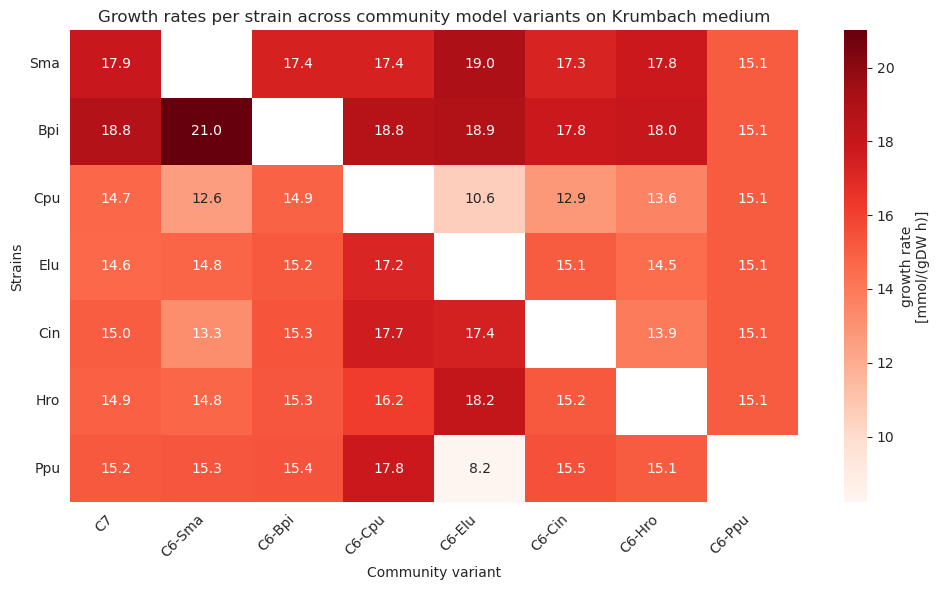

In [89]:
growth_krumbach_df = heatmap_growth_dropouts(all_models, medium_combined_krumbach, "Krumbach", save_path=None)

In [18]:
growth_krumbach_df["row_sum"] = growth_krumbach_df.sum(axis=1)

In [19]:
growth_krumbach_df["row_sum_average"] = growth_krumbach_df.mean(axis=1)

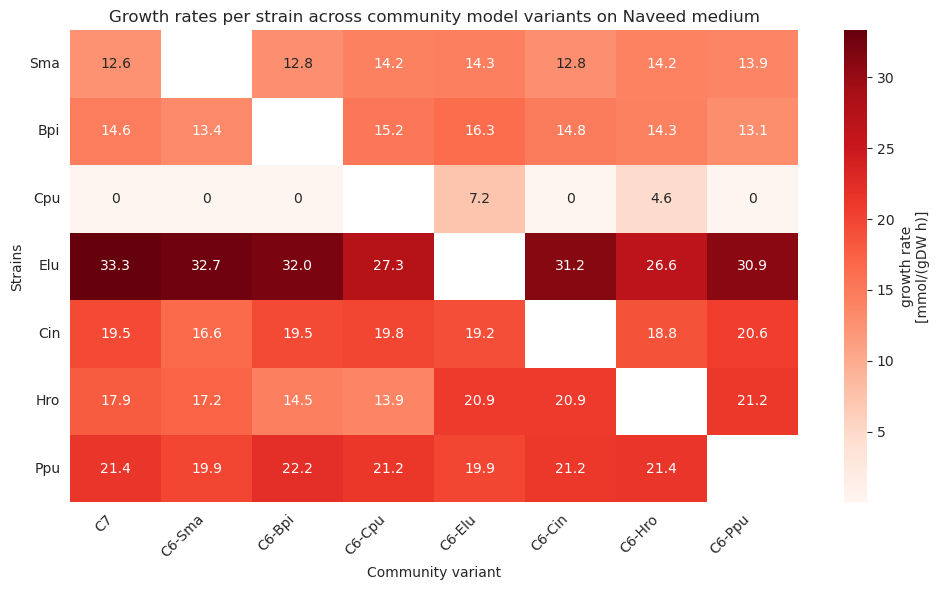

In [92]:
growth_naveed_df = heatmap_growth_dropouts(all_models, medium_combined_naveed, "Naveed", save_path="../../DropOuts_Growth_Naveed.svg")

In [21]:
growth_naveed_df["row_sum"] = growth_naveed_df.sum(axis=1)
growth_naveed_df["row_sum_average"] = growth_naveed_df.mean(axis=1)

# PCA

## PCA - growth values

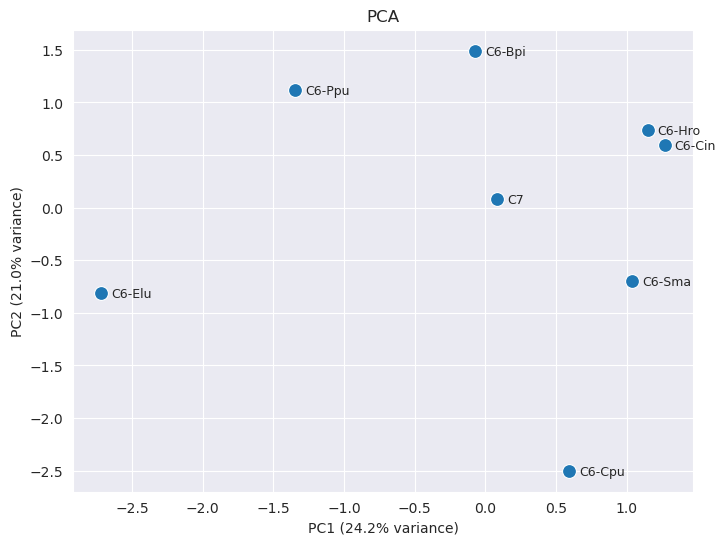

In [39]:
pca(growth_krumbach_df, "../Figures/MA_Results/DropOuts_PCA_Krumbach.svg")

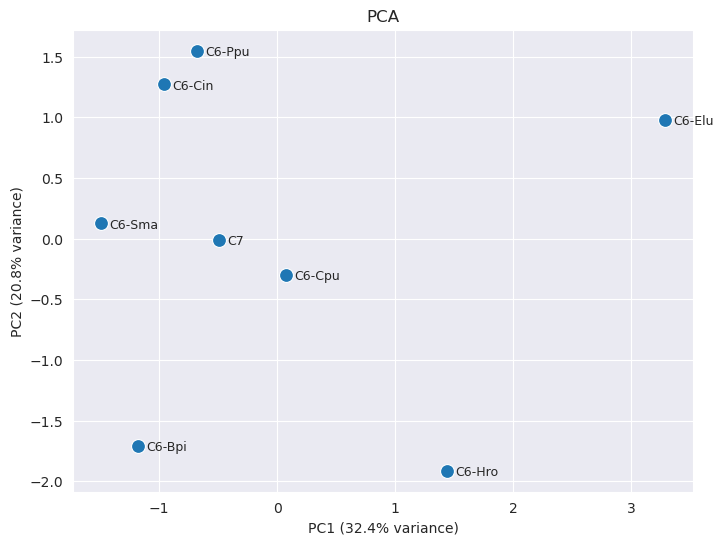

In [43]:
pca(growth_naveed_df, "../Figures/MA_Results/DropOuts_PCA_Naveed.svg")

## PCA - all fluxes

Dimension reduction on all fluxes, not just growth rates

In [15]:
flux_tables = {}

for model_name, model in all_models.items():
    flux_series = get_pfba_fluxes(model, medium_combined_krumbach)  # Krumbach
    flux_tables[model_name] = flux_series

# Combine into one dataframe
big_df = pd.concat(flux_tables, axis=1)

# Replace missing reactions with zero
big_df = big_df.fillna(0)

# set model names as columns (instead of MultiIndex)
big_df.columns = big_df.columns.get_level_values(0)

In [16]:
community_map = { "C7_Community": "C7", "S1": "C6-Sma", "S2": "C6-Bpi", "S3": "C6-Cpu", "S4": "C6-Elu", "S5": "C6-Cin", "S6": "C6-Hro", "S7": "C6-Ppu" }
big_df = big_df.rename(columns=community_map)

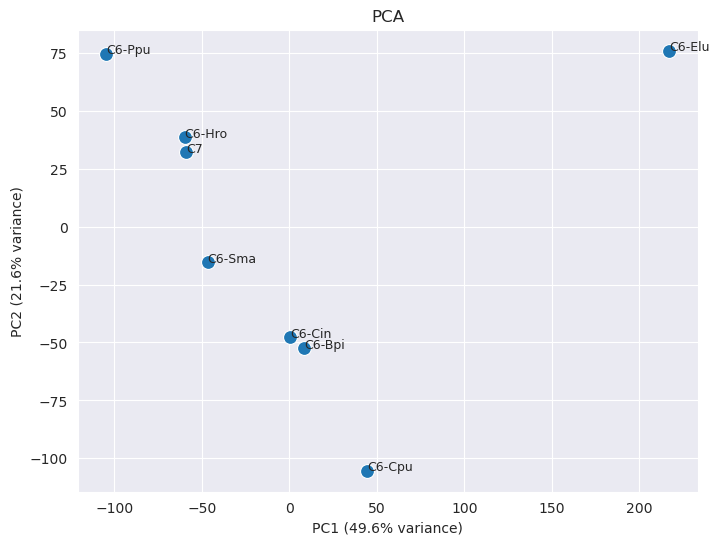

In [63]:
pca(big_df.T, "../Figures/MA_Results/DropOuts_PCA_Krumbach_all.svg") # krumbach

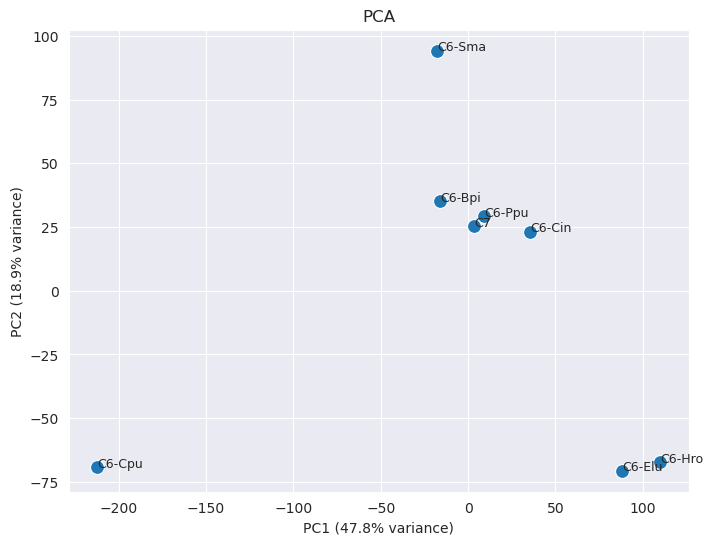

In [17]:
flux_tables = {}

for model_name, model in all_models.items():
    flux_series = get_pfba_fluxes(model, medium_combined_naveed)  # Naveed
    flux_tables[model_name] = flux_series

# Combine into one dataframe
big_df = pd.concat(flux_tables, axis=1)

# Replace missing reactions with zero
big_df = big_df.fillna(0)

# set model names as columns (instead of MultiIndex)
big_df.columns = big_df.columns.get_level_values(0)

big_df = big_df.rename(columns=community_map)

# PCA
pca(big_df.T)

## PCA - exchange fluxes

compare both media but only exchange reactions

In [25]:
# Define media
media_dict = {
    "Krumbach": medium_combined_krumbach,
    "Naveed": medium_combined_naveed
}

# Prepare an empty dict to store fluxes
flux_tables = {}

# Loop over models and media
for model_name, model in all_models.items():
    for medium_name, medium in media_dict.items():
        flux_series = get_pfba_fluxes(model, medium)

        # filter series to only have Exchange reactions and not all reactions
        # because we have a community, this includes exchanges between the models and the shared compartment and the uptake7secretion of the environment with the whole community model
        flux_series = flux_series[flux_series.index.str.startswith("EX")]

        # Store with a combined key (model + medium)
        flux_tables[f"{model_name}_{medium_name}"] = flux_series

In [26]:
# Combine into one dataframe
big_df = pd.concat(flux_tables, axis=1).fillna(0)

df_krumbach = big_df[[col for col in big_df.columns if col.endswith('_Krumbach')]].copy()
df_naveed = big_df[[col for col in big_df.columns if col.endswith('_Naveed')]].copy()

In [47]:
# flatten columns if MultiIndex
if isinstance(big_df.columns, pd.MultiIndex):
    big_df.columns = big_df.columns.get_level_values(0)

# Rename models using community_map
new_cols = []
for col in big_df.columns:
    model, medium = col.rsplit("_", 1)   # split only at the last underscore
    model_name = community_map.get(model, model)
    new_cols.append(f"{model_name}_{medium}")

big_df.columns = [community_map.get(col.rsplit("_", 1)[0], col.rsplit("_", 1)[0])
                  for col in big_df.columns]

# Create a medium mapping for coloring
colooors = sns.color_palette("Set2")
medium_colors = {"Krumbach": colooors[1], "Naveed": colooors[0]}

# Assign colors based on medium in original flux_tables keys
point_colors = [
    medium_colors[col.rsplit("_", 1)[1]]  # last part is medium
    for col in flux_tables.keys()
]


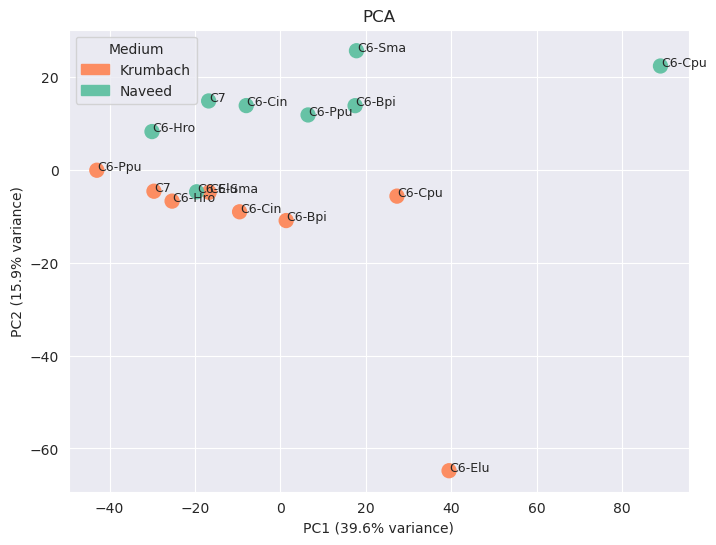

In [92]:
pca2(big_df.T, colors=point_colors, color_legend=medium_colors, save_path="../Figures/MA_Results/DropOuts_PCA_bothMedia_ex.svg")

In [27]:
# Rename models using community_map
new_cols = []
for col in df_krumbach.columns:
    model, medium = col.rsplit("_", 1)   # split only at the last underscore
    model_name = community_map.get(model, model)
    new_cols.append(f"{model_name}_{medium}")

df_krumbach.columns = [community_map.get(col.rsplit("_", 1)[0], col.rsplit("_", 1)[0])
                  for col in df_krumbach.columns]

In [28]:
new_cols = []
for col in df_naveed.columns:
    model, medium = col.rsplit("_", 1)   # split only at the last underscore
    model_name = community_map.get(model, model)
    new_cols.append(f"{model_name}_{medium}")

df_naveed.columns = [community_map.get(col.rsplit("_", 1)[0], col.rsplit("_", 1)[0])
                  for col in df_naveed.columns]

/tmp/ipykernel_206075/726920173.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_df["PC1"], pca_df["PC2"], c=point_colors, s=100)


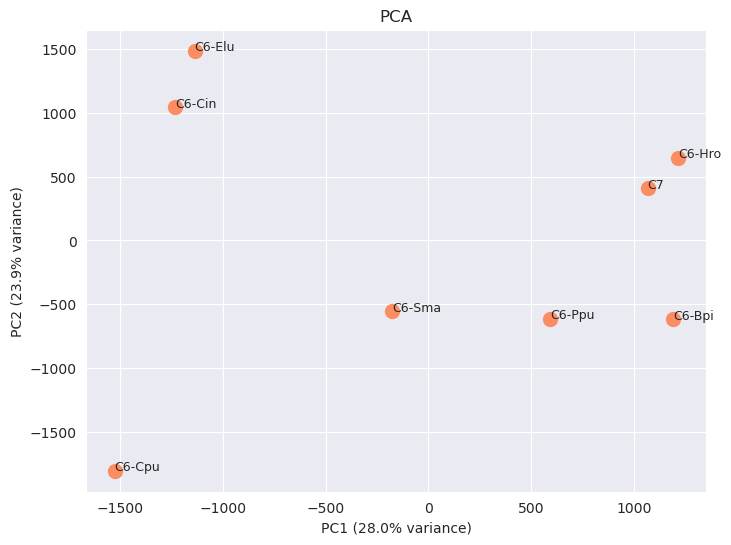

In [134]:
pca2(df_krumbach.T, colors=medium_colors["Krumbach"], scale=False)

/tmp/ipykernel_206075/726920173.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_df["PC1"], pca_df["PC2"], c=point_colors, s=100)


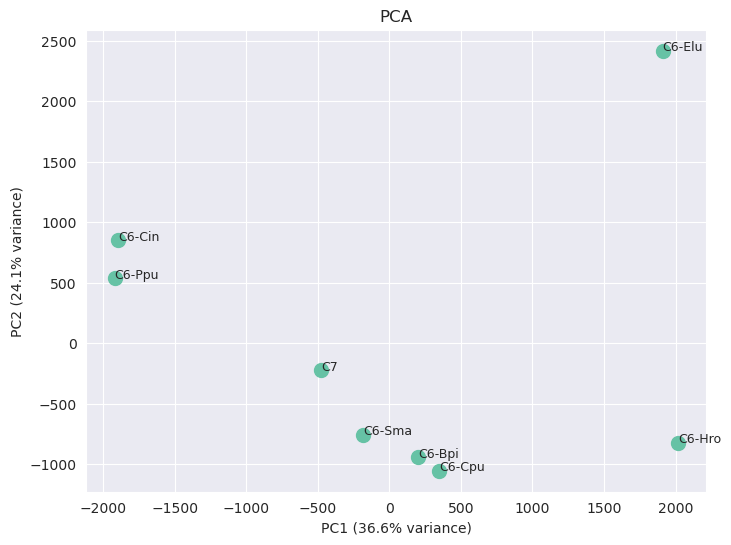

In [132]:
pca2(df_naveed.T, colors=medium_colors["Naveed"], scale=False)

/tmp/ipykernel_206075/846035496.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_df["PC1"], pca_df["PC2"], c=point_colors, s=100)


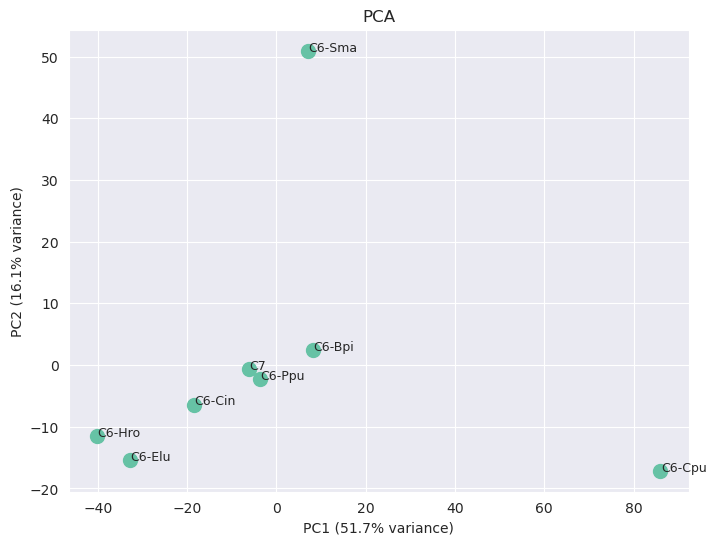

In [126]:
pca2(df_naveed.T, colors=medium_colors["Naveed"], save_path="../../PCA_EX-rxns_DropOuts_Naveed.svg")

/tmp/ipykernel_206075/846035496.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(pca_df["PC1"], pca_df["PC2"], c=point_colors, s=100)


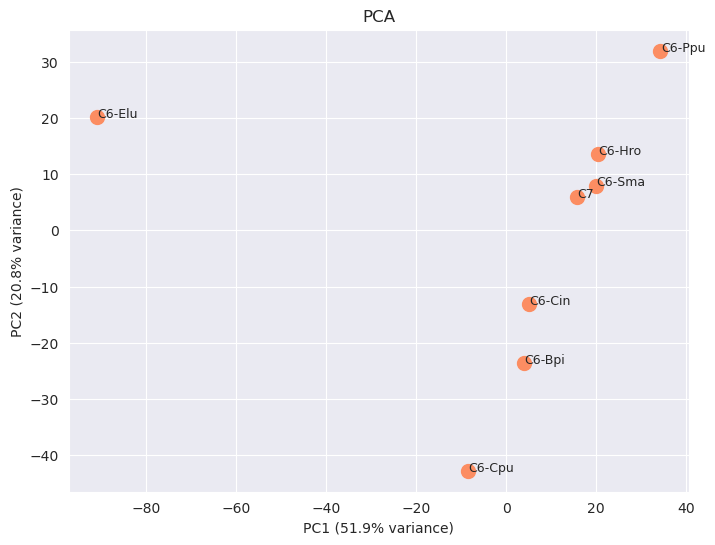

In [127]:
pca2(df_krumbach.T, colors=medium_colors["Krumbach"], save_path="../../PCA_EX-rxns_DropOuts_Krumbach.svg")

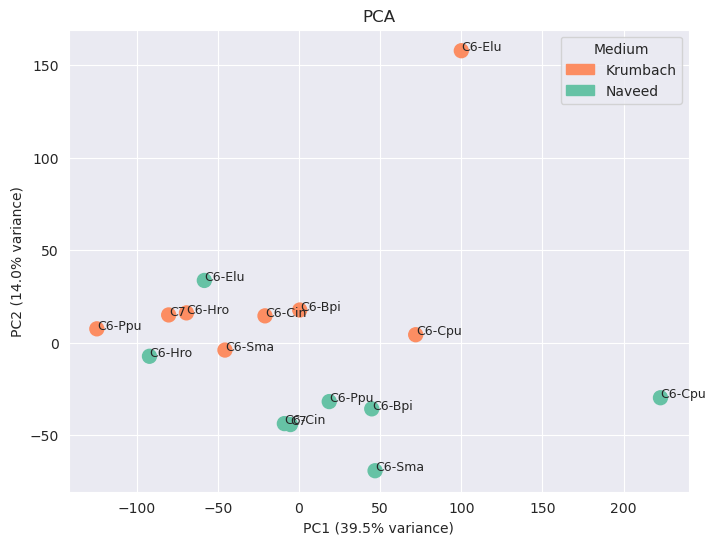

In [82]:
pca2(big_df.T, colors=point_colors, color_legend=medium_colors, save_path="../Figures/MA_Results/DropOuts_PCA_bothMedia_all.svg")

Similarity on only the existence of reactions

In [11]:
# 1) collect all unique reactions
all_rxns = set()
for model in all_models.values():
    all_rxns.update([rxn.id for rxn in model.reactions])

all_rxns = sorted(all_rxns)  # consistent ordering

# 2) fill matrix: rows=reactions, cols=models, values=1/0
binary_df = pd.DataFrame(0, index=all_rxns, columns=all_models.keys())

for model_name, model in all_models.items():
    model_rxns = [rxn.id for rxn in model.reactions]
    binary_df.loc[model_rxns, model_name] = 1


In [29]:
community_map = { "C7_Community": "C7", "S1": "C6-Sma", "S2": "C6-Bpi", "S3": "C6-Cpu", "S4": "C6-Elu", "S5": "C6-Cin", "S6": "C6-Hro", "S7": "C6-Ppu" }
binary_df = binary_df.rename(columns=community_map)

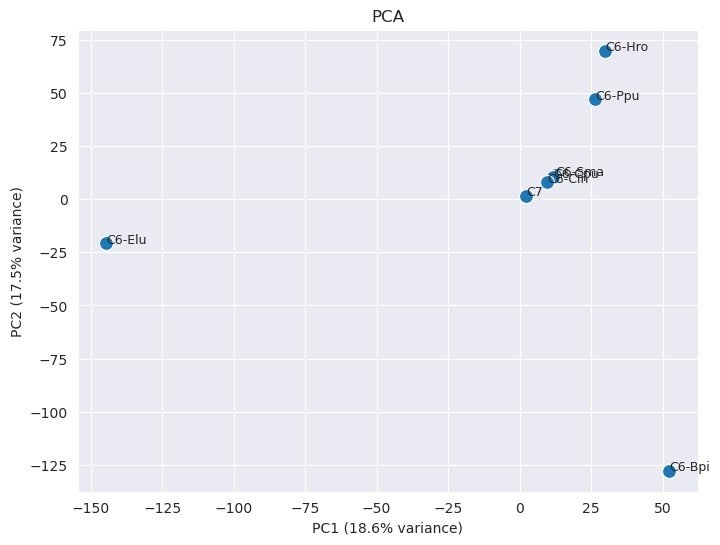

In [32]:
pca(binary_df.T) # in theory PCA is not so good for binary/discrete data

# PCoA

In [18]:
# 1) convert to boolean and transpose once
binary_bool = binary_df.T.astype(bool)          # models × reactions

# 2) compute Jaccard distance
jaccard_dist = pairwise_distances(binary_bool.values, metric="jaccard")

# 3) convert to similarity matrix
jaccard_sim = 1 - jaccard_dist
jaccard_sim_df = pd.DataFrame(jaccard_sim,
                              index=binary_df.columns,
                              columns=binary_df.columns)

jaccard_sim_df


,S1,S2,S3,S4,S5,S6,S7,C7_Community
S1,1.000000,0.720651,0.746344,0.710769,0.752612,0.726071,0.727766,0.872042
S2,0.720651,1.000000,0.722909,0.687334,0.729177,0.702637,0.704331,0.848608
S3,0.746344,0.722909,1.000000,0.713027,0.754870,0.728330,0.730024,0.874301
S4,0.710769,0.687334,0.713027,1.000000,0.719295,0.692755,0.694449,0.838726
S5,0.752612,0.729177,0.754870,0.719295,1.000000,0.734598,0.736292,0.880569
S6,0.726071,0.702637,0.728330,0.692755,0.734598,1.000000,0.709752,0.854029
S7,0.727766,0.704331,0.730024,0.694449,0.736292,0.709752,1.000000,0.855723
C7_Community,0.872042,0.848608,0.874301,0.838726,0.880569,0.854029,0.855723,1.000000


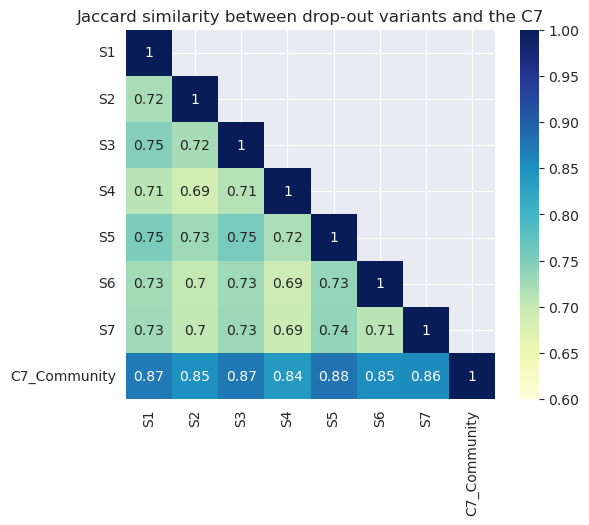

In [59]:
jaccard_df = pd.DataFrame(
    jaccard_sim,
    index=binary_bool.index,
    columns=binary_bool.index
)

# jaccard_df is your square similarity matrix
mask = np.triu(np.ones_like(jaccard_df, dtype=bool), k=1)

sns.heatmap(
    jaccard_df,
    mask=mask,
    annot=True,
    cmap="YlGnBu",
    square=True,
    cbar=True,
    vmin=0.6, vmax=1
)

plt.title("Jaccard similarity between drop-out variants and the C7")
plt.savefig("../Figures/MA_Results/DropOuts_Jaccard.svg", format="svg")
plt.show()


/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.012189479263315907 whereas the largest positive one is 0.05013813769086461.
  warn(


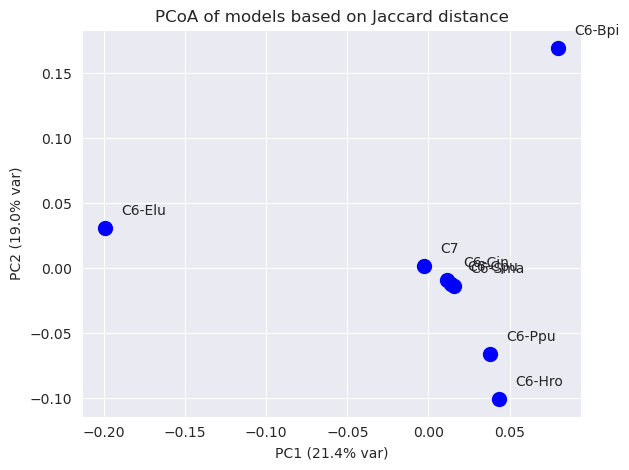

In [58]:
from skbio.stats.ordination import pcoa
# https://www.geeksforgeeks.org/machine-learning/principal-coordinates-analysis-pcoa-a-comprehensive-guide/
# https://files.cercomp.ufg.br/weby/up/417/o/Numerical_Ecology.pdf?1458165083

# jaccard_dist is distance matrix (distance not similarity)
jaccard_dist_df = pd.DataFrame(jaccard_dist, index=binary_df.columns, columns=binary_df.columns)

# Run PCoA
pcoa_results = pcoa(jaccard_dist_df)

# Get the coordinates for the first two axes
coords = pcoa_results.samples.iloc[:, 0:2]

group_colors = {
    "C6-Sma": "blue",
    "C6-Bpi": "green",
    "C6-Cpu": "purple",
    "C6-Elu": "orange",
    "C6-Cin": "brown",
    "C6-Hro": "pink",
    "C6-Ppu": "cyan",
    "C7": "red"
}
coords_df = coords.copy()
coords_df.index = binary_df.columns
coords_df.index = [community_map.get(x, x) for x in binary_df.columns]


# Plot
for model in coords_df.index:
    plt.scatter(
        coords_df.loc[model, coords_df.columns[0]],
        coords_df.loc[model, coords_df.columns[1]],
        s=100,
        color="blue",
        label=model
    )
    # Optional: add text labels next to points
    plt.text(
        coords_df.loc[model, coords_df.columns[0]] + 0.01,
        coords_df.loc[model, coords_df.columns[1]] + 0.01,
        model,
        fontsize=10
    )


# Get proportion of variance explained
explained_var = pcoa_results.proportion_explained

plt.xlabel(f"{coords_df.columns[0]} ({explained_var[0]*100:.1f}% var)")
plt.ylabel(f"{coords_df.columns[1]} ({explained_var[1]*100:.1f}% var)")
plt.title("PCoA of models based on Jaccard distance")
plt.grid(True)
plt.tight_layout()
#plt.savefig("../Figures/MA_Results/DropOuts_PCoA_reactions.svg", format="svg")
plt.show()

# t-SNE
Gesundheit

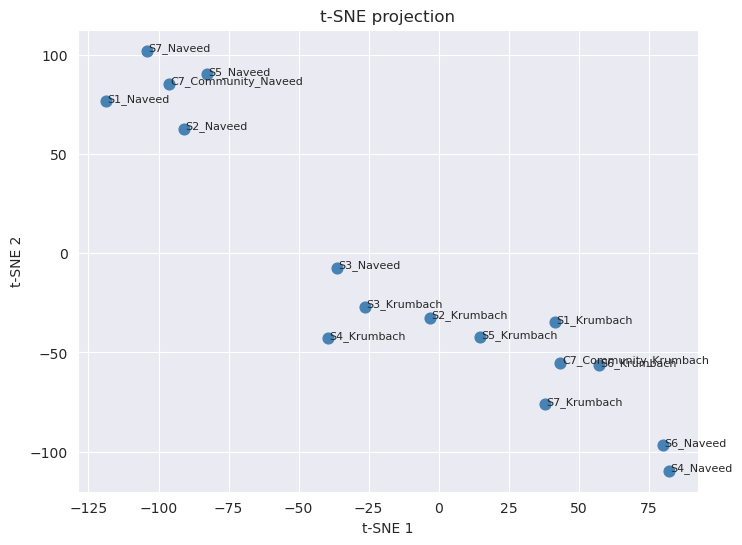

In [33]:
tsne(big_df.T, perplex=2)

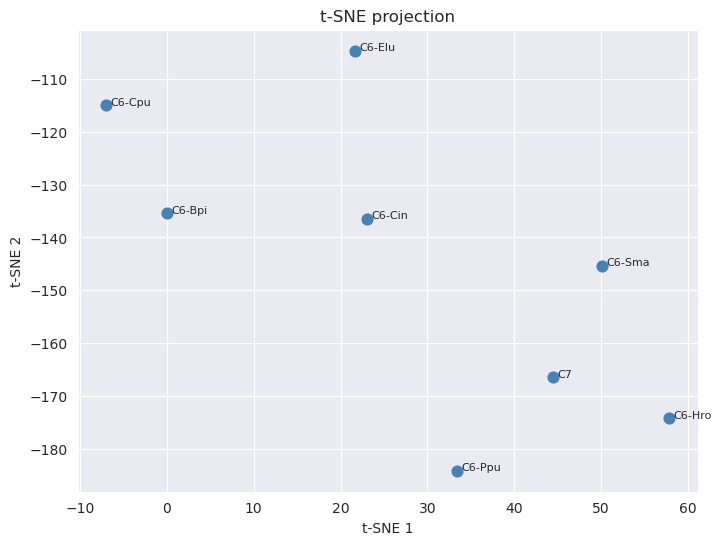

In [29]:
tsne(df_krumbach.T, perplex=2)

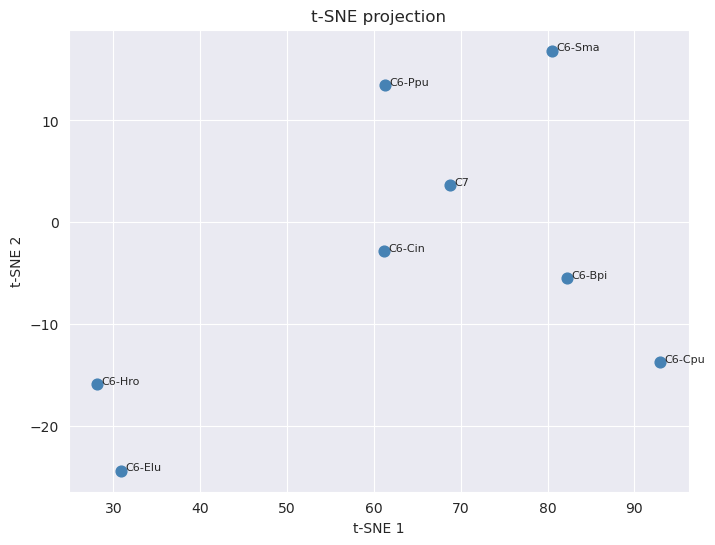

In [30]:
tsne(df_naveed.T, perplex=2)

# UMAP

/tmp/ipykernel_13078/2361709107.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], c=point_colors, s=100)


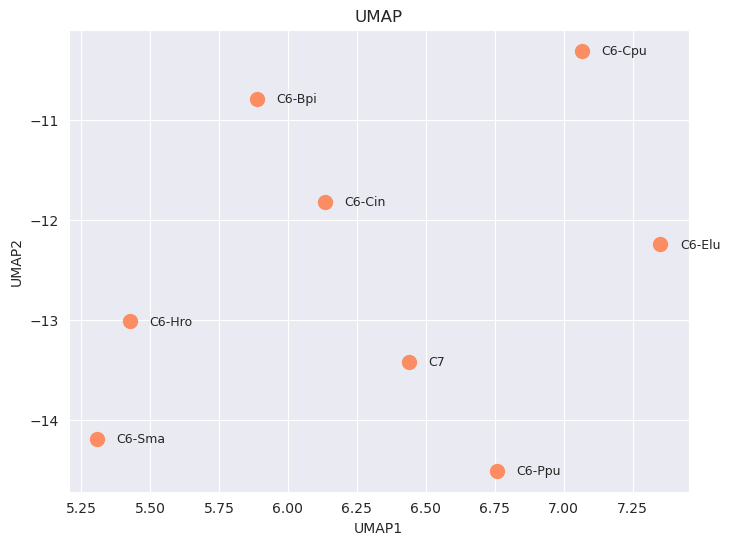

In [77]:
umap2(df_krumbach.T, colors=medium_colors["Krumbach"], min_dist=0.6, save_path="../../DropOuts_UMAP_Krumbach.svg")

/tmp/ipykernel_13078/2361709107.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(umap_df["UMAP1"], umap_df["UMAP2"], c=point_colors, s=100)


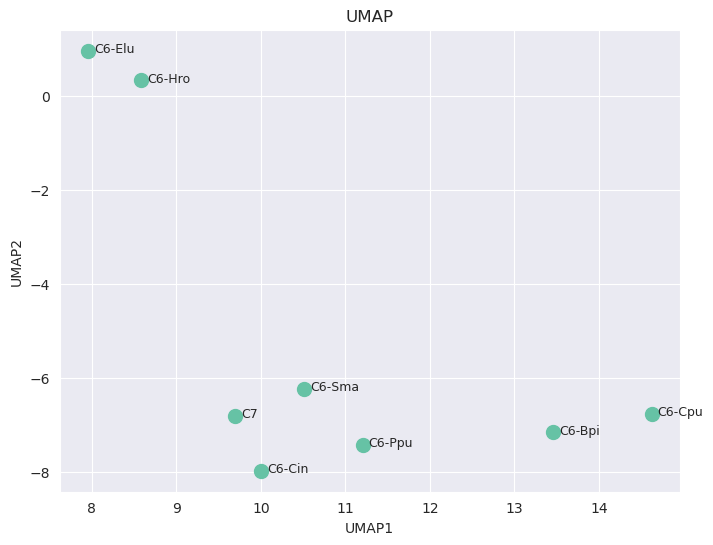

In [78]:
umap2(df_naveed.T, colors=medium_colors["Naveed"], min_dist=0.6, save_path="../../DropOuts_UMAP_Naveed.svg")

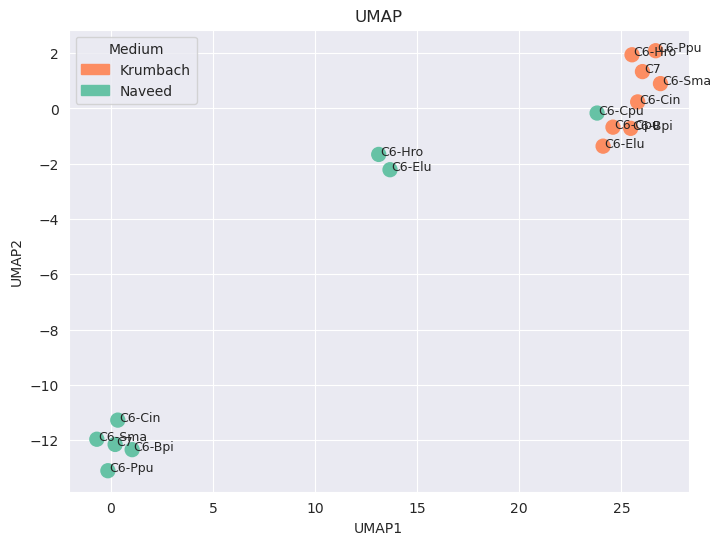

In [80]:
umap2(big_df.T, colors=point_colors, color_legend=medium_colors, min_dist=0.6, save_path="../../DropOuts_UMAP_bothMedia.svg")

# MDS

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/tmp/ipykernel_13078/2303888261.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(mds_df["MDS1"], mds_df["MDS2"], c=point_colors, s=100)


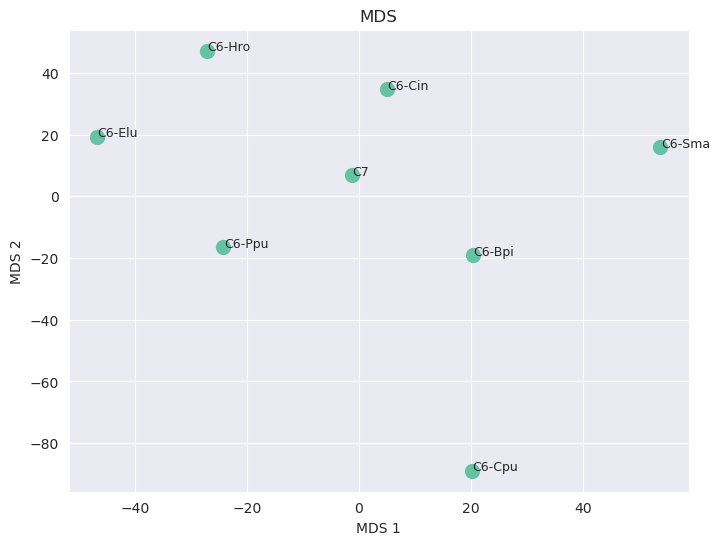

In [52]:
mds2(df_naveed.T, colors=medium_colors["Naveed"], save_path="../../DropOuts_MDS_Naveed.svg")

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/tmp/ipykernel_13078/2303888261.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(mds_df["MDS1"], mds_df["MDS2"], c=point_colors, s=100)


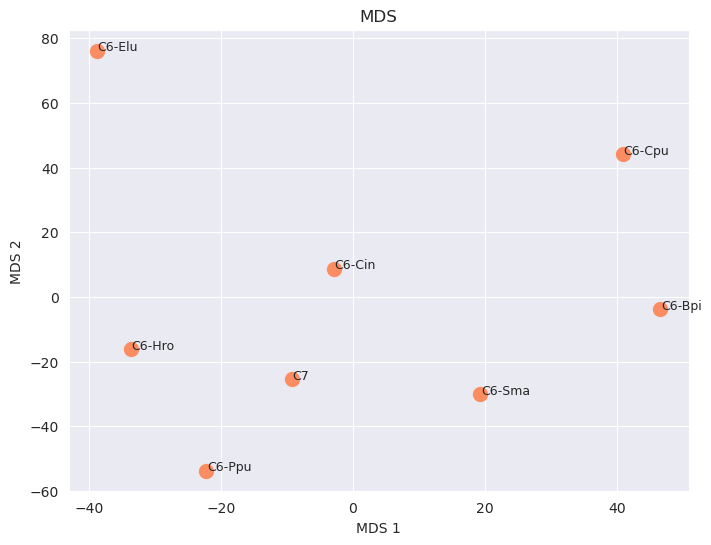

In [51]:
mds2(df_krumbach.T, colors=medium_colors["Krumbach"], save_path="../../DropOuts_MDS_Krumbach.svg")

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


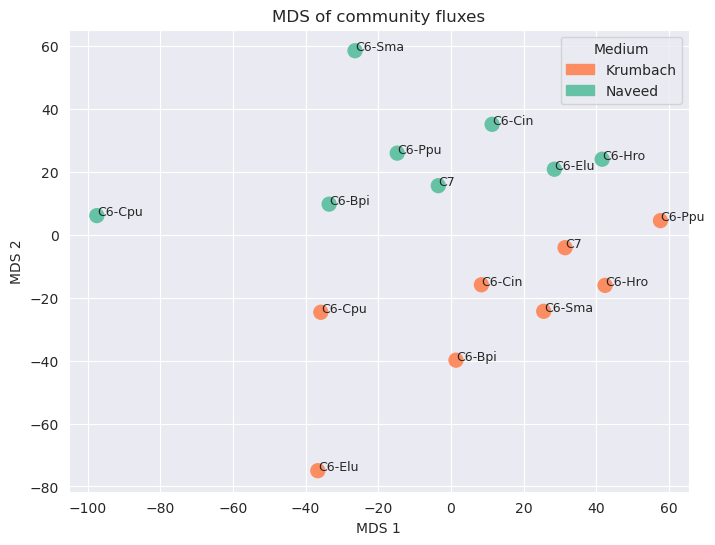

In [50]:
mds2(big_df.T, colors=point_colors, color_legend=medium_colors, title="MDS of community fluxes")

# Growth on Single Carbon Sources

In [11]:
carbon_sources = ["EX_glc__D_e", "EX_sucr_e", "EX_xyl__D_e", ["EX_mal__L_e", "EX_mal__L_e"], "EX_pyr_e", "EX_succ_e", ["EX_ala__L_e", "EX_ala__L_e"], "EX_glu__L_e", "EX_gly_e"]

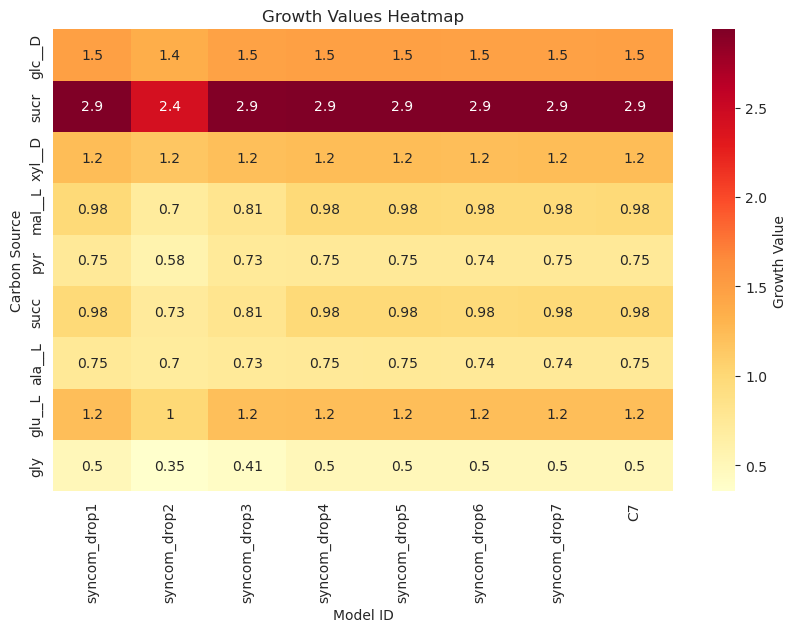

In [12]:
carbon_df = create_medium(carbon_sources, m9_rxn, all_models, 10, carbon_only=True)

# Substrate Utilisation (BIOLOG Ecoplate)

def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):

In [93]:
metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "4-Hydroxy benzoic acid", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]

In [ ]:
ecoplate_df = create_medium(ecoplate_rxns, m9_rxn, all_models, 10, carbon_only=True, average="yes")
# takes around 9min

In [29]:
# Ensure numeric
ecoplate_df = ecoplate_df.apply(pd.to_numeric, errors='coerce')
annot_str = ecoplate_df.applymap(custom_format)

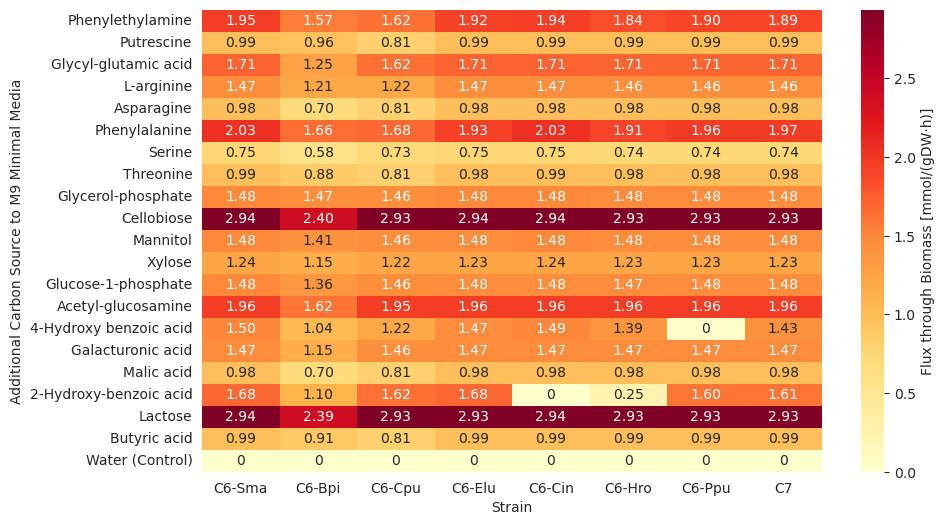

In [30]:
# for nicer visualisation: better labels
ecoplate_df.index = metab_axis
ecoplate_df.columns = ["C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu", "C7"]
ecoplate_df = ecoplate_df.fillna(0)
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ecoplate_df, annot=annot_str, fmt="", cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
#plt.yticks(ticks=np.arange(len(metab_axis)), labels=metab_axis)
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
plt.savefig("../Figures/dropouts_ecoplate.svg", format="svg", bbox_inches="tight")
plt.show()

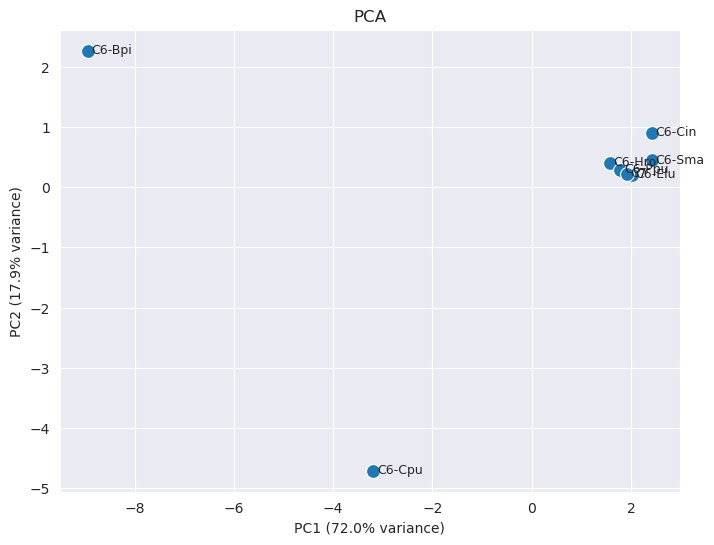

In [23]:
pca(ecoplate_df.T, save_path="../Figures/dropouts_ecoplate_PCA.svg")

[10/28/25 09:36:31] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=700010;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=708978;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:32] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=478245;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=461370;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:34] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=919035;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=976650;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:37] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=184711;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=381064;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:39] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=486541;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=805314;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:41] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=912031;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=768152;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:43] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=398311;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=510621;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:44] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=602826;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=176849;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

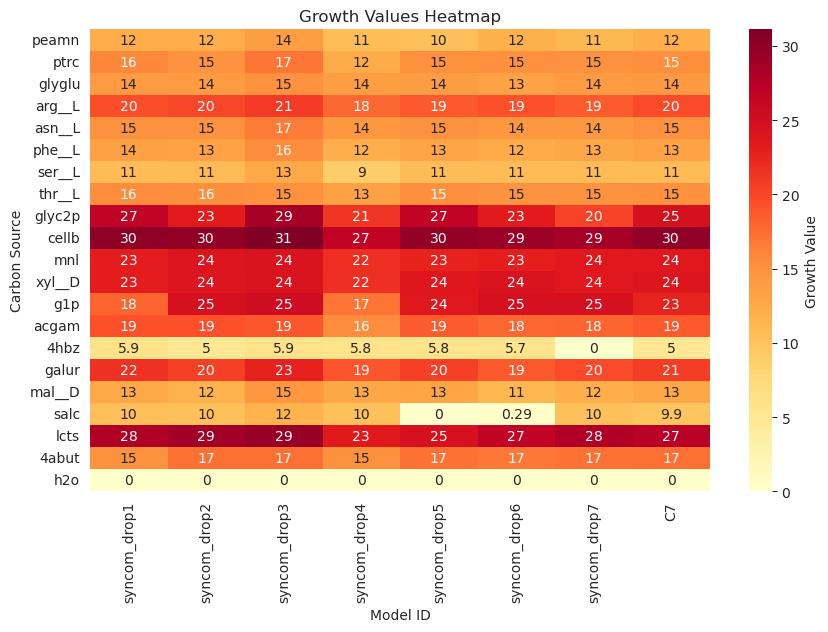

In [15]:
ecoplate_df_highcarbon = create_medium(ecoplate_rxns, m9_rxn, all_models, 1000, carbon_only=True, average="yes")

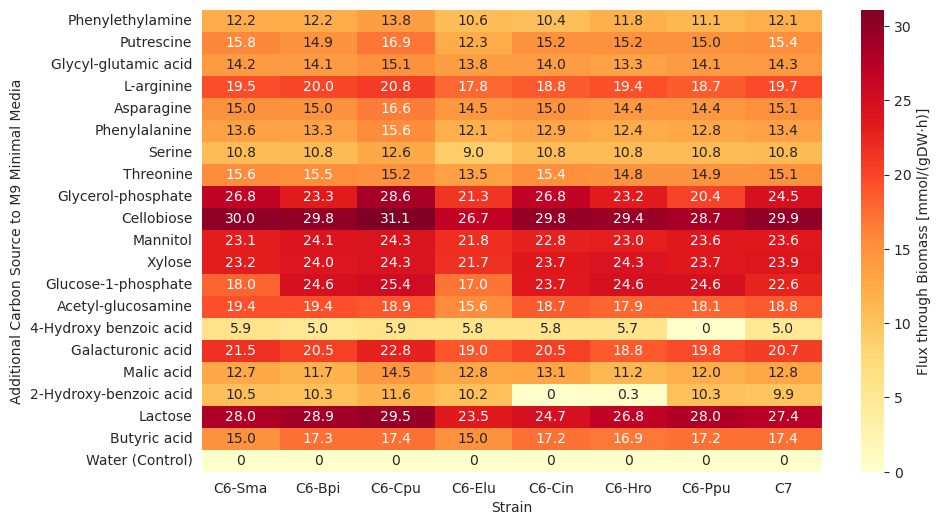

In [28]:
ecoplate_df_highcarbon = ecoplate_df_highcarbon.apply(pd.to_numeric, errors='coerce')
annot_str = ecoplate_df_highcarbon.applymap(custom_format)

# for nicer visualisation: better labels
ecoplate_df_highcarbon.index = metab_axis
ecoplate_df_highcarbon.columns = ["C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu", "C7"]
ecoplate_df_highcarbon = ecoplate_df_highcarbon.fillna(0)
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ecoplate_df_highcarbon, annot=annot_str,fmt="", cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
#plt.yticks(ticks=np.arange(len(metab_axis)), labels=metab_axis)
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
#plt.savefig("../Figures/MA_Results/dropouts_ecoplateHIGH.svg", format="svg", bbox_inches="tight")
plt.show()

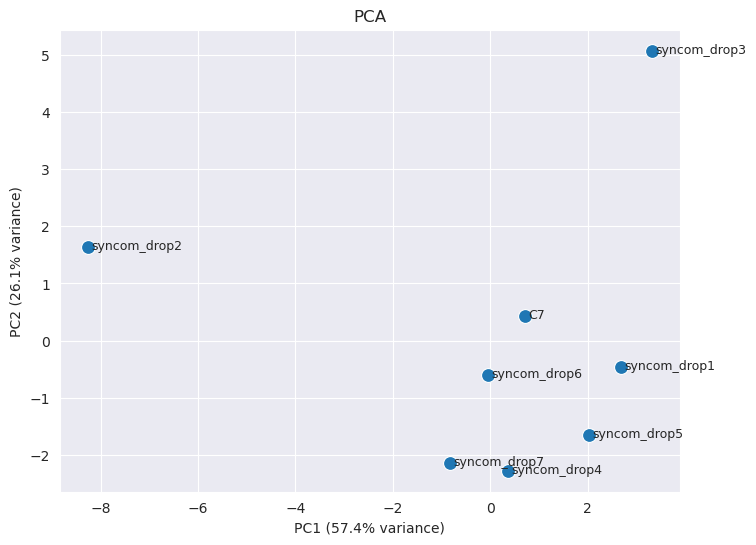

In [14]:
pca(ecoplate_df_highcarbon.T)
#pca(ecoplate_df_highcarbon.T, save_path="../Figures/dropouts_ecoplateHIGH_PCA.svg")

# Uptakes and Secretions

## One community within

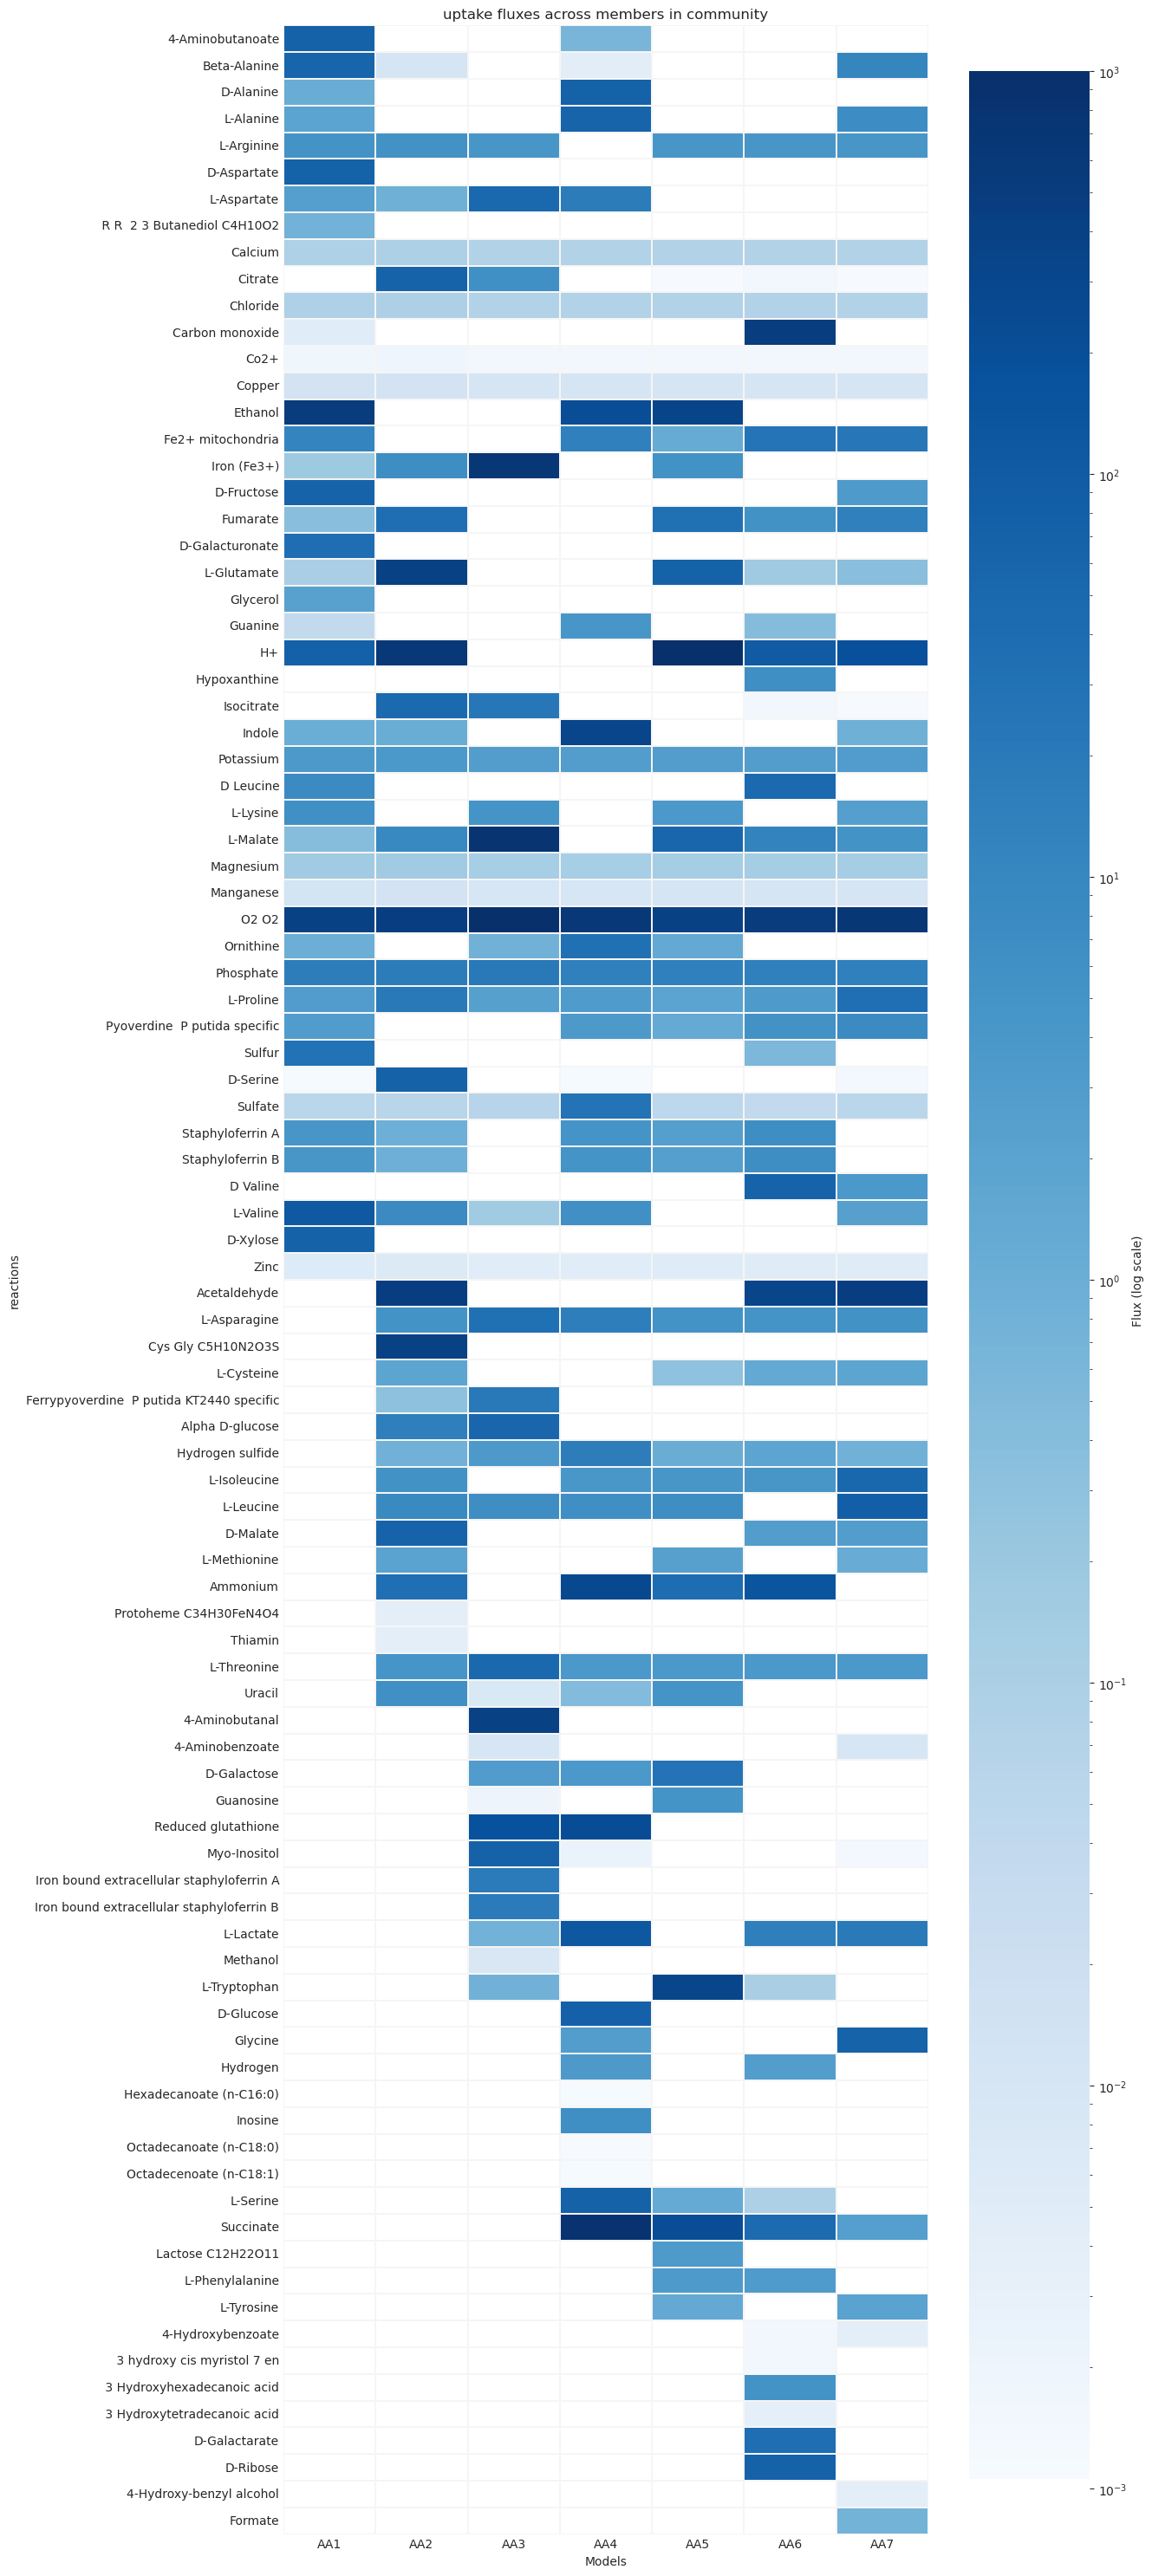

In [36]:
heatmap_fluxes_withinCommunity(syncom, models, medium_combined_krumbach, "uptake")

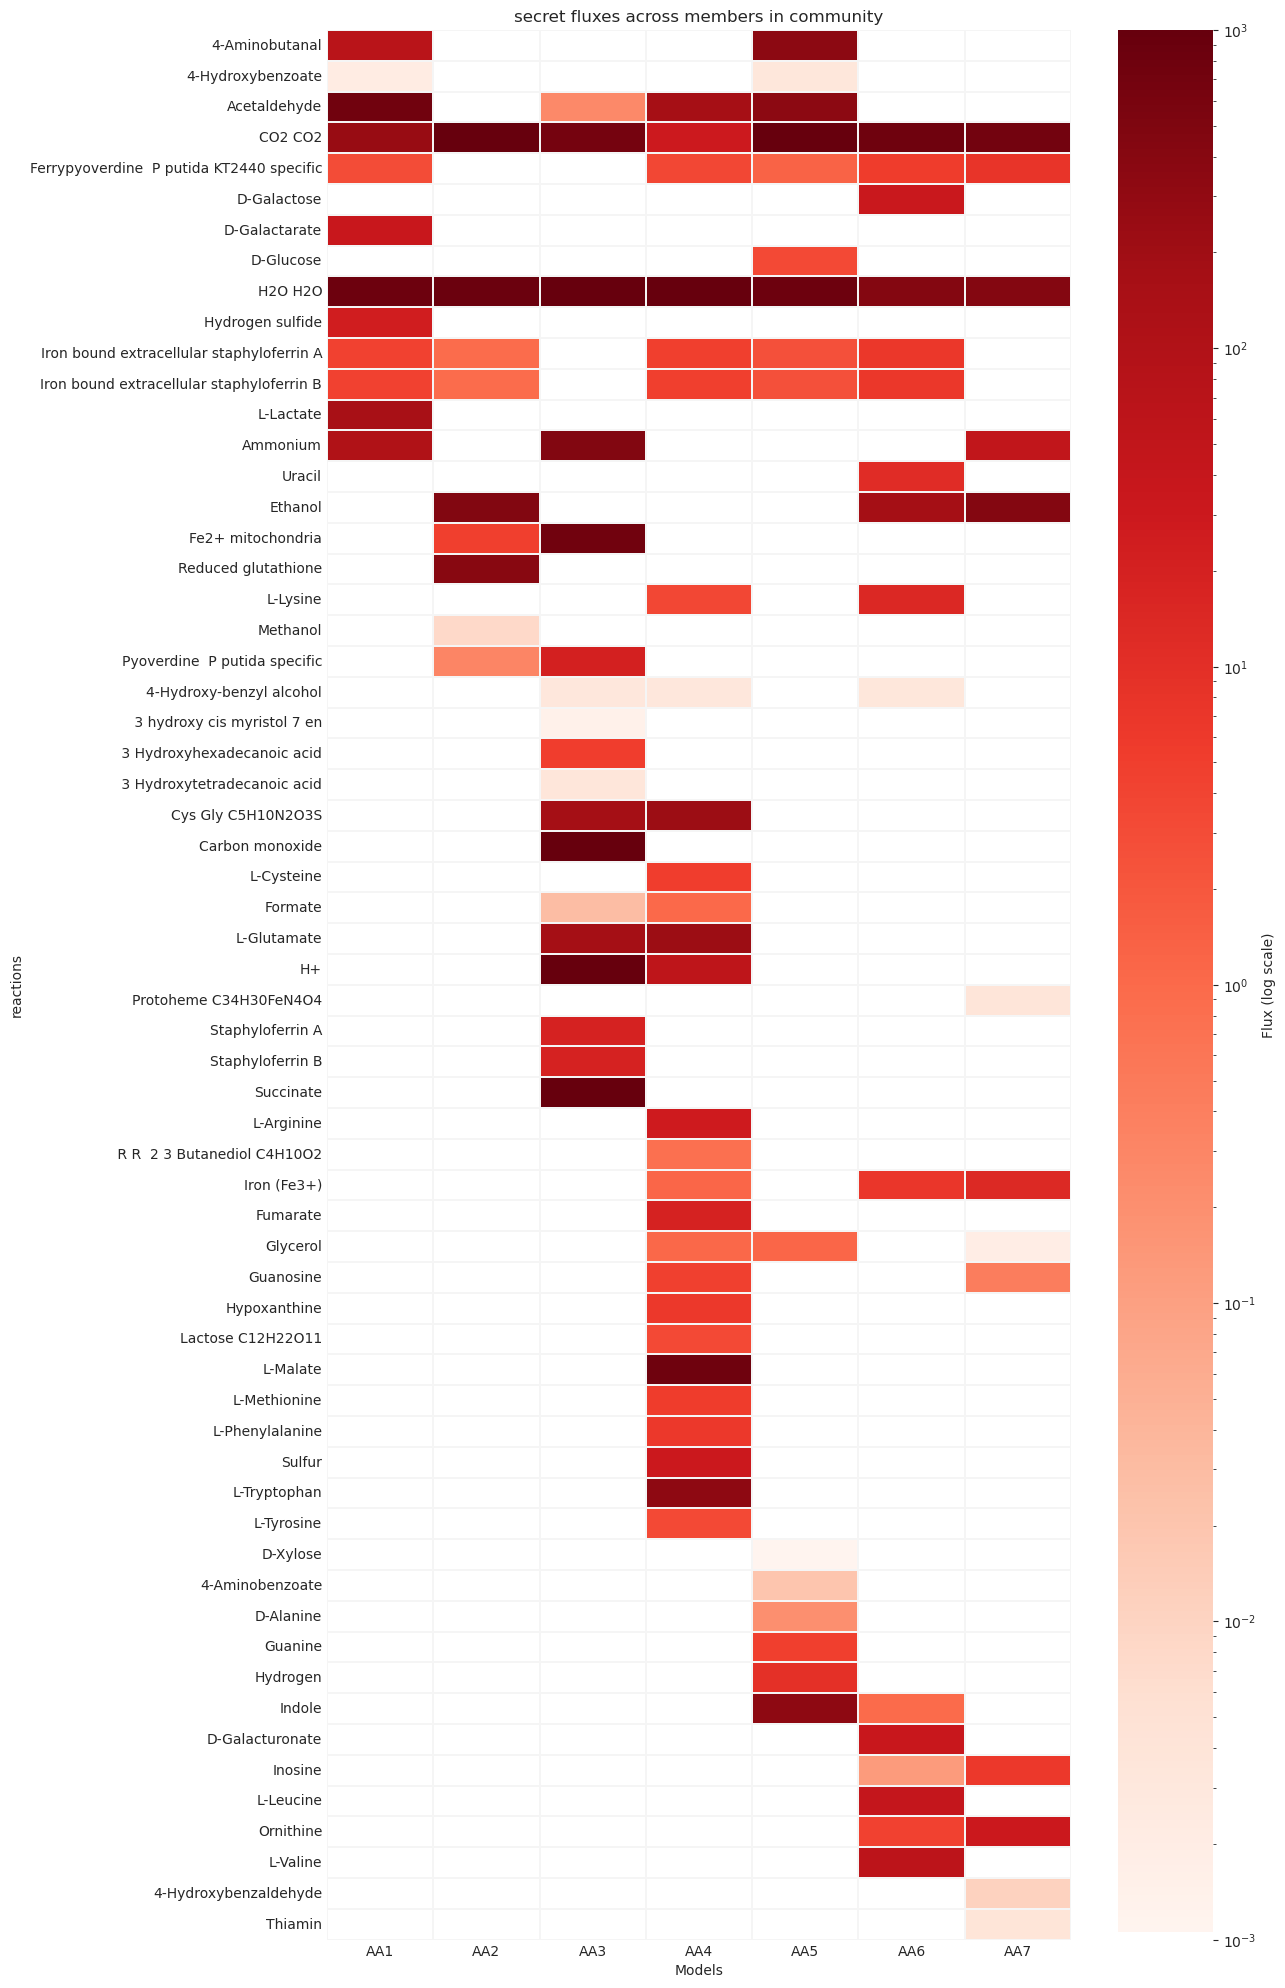

In [37]:
heatmap_fluxes_withinCommunity(syncom, models, medium_combined_krumbach, "secret")

## across all drop out communities

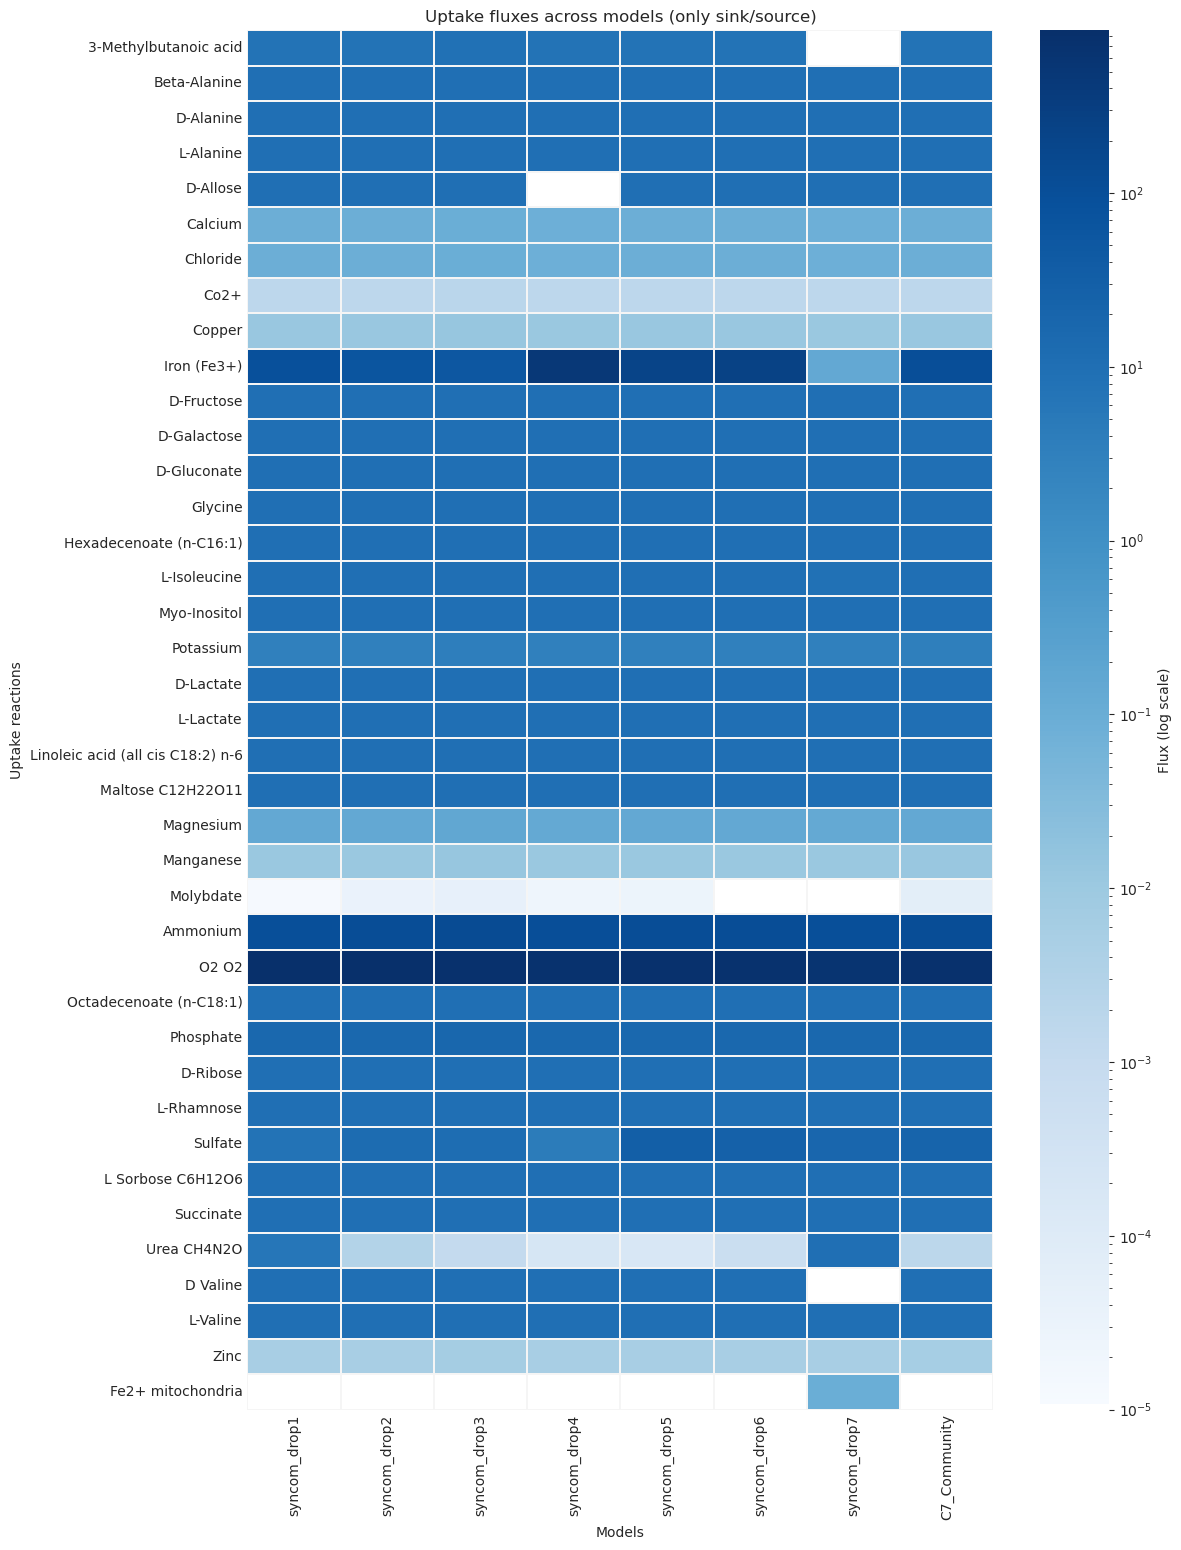

In [18]:
uptake_df_alldrops = uptake_secret_heatmap(all_models, "uptake", medium_combined_naveed, c7_all_ex = "no")

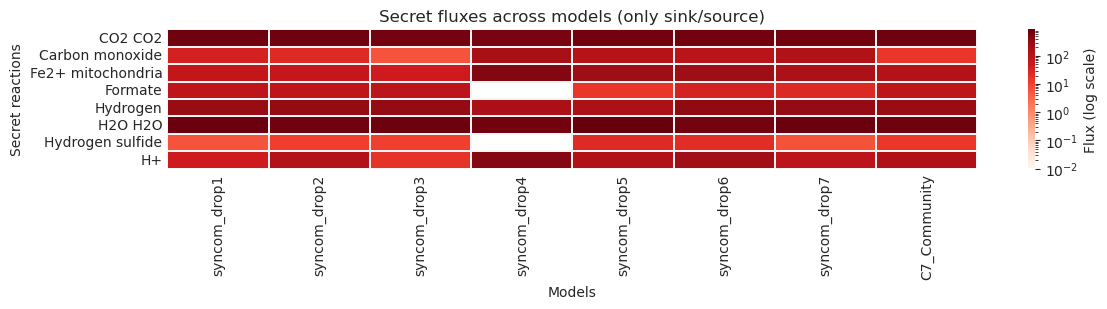

In [20]:
secret_df_alldrops = uptake_secret_heatmap(all_models, "secret", medium_combined_naveed, c7_all_ex = "no", vmin=0.01)

# Community Fractions

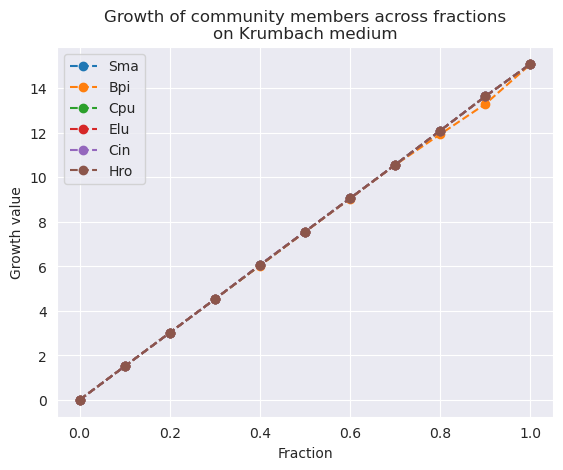

In [10]:
test_fractions_community(S7, medium_combined_krumbach, drop_out="Ppu", medium_name="Krumbach")

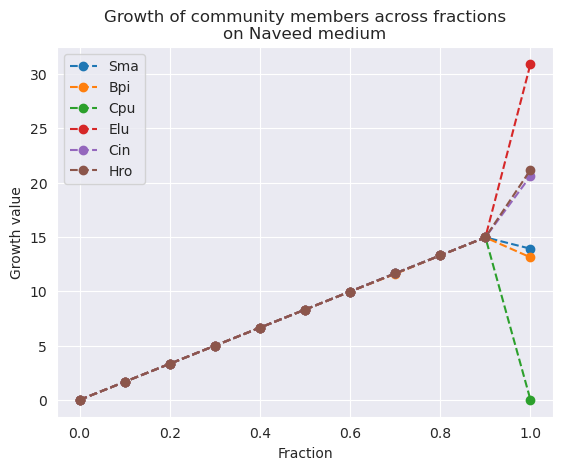

In [14]:
test_fractions_community(S7, medium_combined_naveed, drop_out="Ppu", medium_name="Naveed")